# Indoor localization using deep learning with DNN and KNN

## 1. Importing the packages

In [142]:
import pandas as pd
import numpy as np
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import torch
from sklearn.preprocessing import scale, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, classification_report
from sklearn.neighbors import KNeighborsRegressor
import geopy.distance
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

## 2. Importing the data

### 2.1. UJIIndoorLoc dataset
* Dataset: UJIIndoorLoc (https://archive.ics.uci.edu/ml/datasets/ujiindoorloc)
* 529 attributes and 19937 rows

In [143]:
# UJIIndoorloc dataset
dataset_ujloc = pd.read_csv("../data/UJIndoorLoc/trainingData.csv")
validation_dataset_ujloc = pd.read_csv("../data/UJIndoorLoc/validationData.csv")
dataset_ujloc.head(5)

WAP001  WAP002  WAP003  WAP004  WAP005  WAP006  WAP007  WAP008  WAP009  \
0     100     100     100     100     100     100     100     100     100   
1     100     100     100     100     100     100     100     100     100   
2     100     100     100     100     100     100     100     -97     100   
3     100     100     100     100     100     100     100     100     100   
4     100     100     100     100     100     100     100     100     100   

   WAP010  ...  WAP520  LONGITUDE      LATITUDE  FLOOR  BUILDINGID  SPACEID  \
0     100  ...     100 -7541.2643  4.864921e+06      2           1      106   
1     100  ...     100 -7536.6212  4.864934e+06      2           1      106   
2     100  ...     100 -7519.1524  4.864950e+06      2           1      103   
3     100  ...     100 -7524.5704  4.864934e+06      2           1      102   
4     100  ...     100 -7632.1436  4.864982e+06      0           0      122   

   RELATIVEPOSITION  USERID  PHONEID   TIMESTAMP  
0                 2       2       23  1371713733  
1                 2       2       23  1371713691  
2                 2       2       23  1371714095  
3                 2       2       23  1371713807  
4                 2      11       13  1369909710  

[5 rows x 529 columns]

In [144]:
# print(dataset.shape)
# print(dataset[dataset['BUILDINGID'] == 0].shape)
# print(dataset[dataset['BUILDINGID'] == 1].shape)
# print(dataset[dataset['BUILDINGID'] == 2].shape)
dataset_ujloc = dataset_ujloc[dataset_ujloc['BUILDINGID'] == 2]
validation_dataset_ujloc = validation_dataset_ujloc[validation_dataset_ujloc['BUILDINGID'] == 2]

### 2.2. PrecisLoc dataset

In [145]:
# PrecisLoc dataset
dataset_dir = "../../data_PrecisLoc/FINAL_PRECISLOC_DATASET"
dataset_scen_1 = os.path.join(dataset_dir, "Scenario_1", "11-05-07")
dataset_scen_1

'../../data_PrecisLoc/FINAL_PRECISLOC_DATASET\\Scenario_1\\11-05-07'

In [146]:
for filename in os.listdir(dataset_scen_1):
    if filename.startswith("Sensor"):
        sensor_readings = filename
    if filename.startswith("ground"):
        ground_truth = filename

print(sensor_readings)
print(ground_truth)

Sensor_readings_11-05-07.xml
ground_truth_11-05-07.xml


In [147]:
sensor_read_scen_1 = os.path.join(dataset_scen_1, sensor_readings)
ground_truth_scen_1 = os.path.join(dataset_scen_1, ground_truth)
sensor_read_scen_1

'../../data_PrecisLoc/FINAL_PRECISLOC_DATASET\\Scenario_1\\11-05-07\\Sensor_readings_11-05-07.xml'

In [148]:
# Getting the unique MAC addresses of APs
tree = ET.parse(sensor_read_scen_1)

ap_list = [] 
for r in tree.iter(tag='r'):
    ap_list.append(r.attrib['b'])

ap_set = set(ap_list)
ap_set

{'32:cd:a7:a0:6d:d8',
 '84:b2:61:40:75:f0',
 '84:b2:61:40:75:f1',
 '84:b2:61:40:75:f2',
 '84:b2:61:47:dd:40',
 '84:b2:61:47:dd:41',
 '84:b2:61:47:dd:42',
 '84:b2:61:47:dd:4d',
 '84:b2:61:47:dd:4e',
 '84:b2:61:47:dd:4f',
 '84:b2:61:47:e2:c0',
 '84:b2:61:47:e2:c1',
 '84:b2:61:47:e2:c2',
 '84:b2:61:47:e2:cd',
 '84:b2:61:47:e2:ce',
 '84:b2:61:56:8a:00',
 '84:b2:61:56:8a:01',
 '84:b2:61:56:8a:02',
 '84:b2:61:56:8a:0d',
 '84:b2:61:56:8a:0e',
 '84:b2:61:56:8a:0f',
 '84:b2:61:5e:44:20',
 '84:b2:61:5e:44:21',
 '84:b2:61:5e:44:22',
 '84:b2:61:5e:44:2d',
 '84:b2:61:5e:44:2e',
 '84:b2:61:5e:44:2f',
 '84:b2:61:6d:3d:20',
 '84:b2:61:6d:3d:21',
 '84:b2:61:6d:3d:22',
 '84:b2:61:6d:3d:2d',
 '84:b2:61:6d:3d:2e',
 '84:b2:61:6d:3d:2f',
 '84:b2:61:6d:52:a0',
 '84:b2:61:6d:52:a1',
 '84:b2:61:6d:52:a2',
 '84:b2:61:6d:52:af',
 '84:b2:61:6d:5d:70',
 '84:b2:61:6d:5d:71',
 '84:b2:61:6d:5d:72',
 'c4:71:54:39:70:e4'}

In [149]:
# Reading the Sensor Readings for the scenario 1, 11-05-07
tree = ET.parse(sensor_read_scen_1)

time_data_ap_dict = {}

for wr in tree.iter(tag = 'wr'):
    time_data_ap_dict[wr.attrib['st']] = wr.iter(tag='r')

# for key in time_data_dict:
#     print(key, ': ', time_data_dict[key])
#     for r in time_data_dict[key]:
#         print(r.attrib)
time_data_ap_dict

{'11:05:09:00': <_elementtree._element_iterator at 0x2520c5715e0>,
 '11:05:10:00': <_elementtree._element_iterator at 0x2520c571590>,
 '11:05:11:00': <_elementtree._element_iterator at 0x2520c571540>,
 '11:05:12:00': <_elementtree._element_iterator at 0x2520c5714f0>,
 '11:05:13:00': <_elementtree._element_iterator at 0x2520c5714a0>,
 '11:05:14:00': <_elementtree._element_iterator at 0x2520c571450>,
 '11:05:17:00': <_elementtree._element_iterator at 0x2520c571400>,
 '11:05:20:00': <_elementtree._element_iterator at 0x2520c5713b0>,
 '11:05:21:00': <_elementtree._element_iterator at 0x2520c571310>,
 '11:05:22:00': <_elementtree._element_iterator at 0x2520c5716d0>,
 '11:05:23:00': <_elementtree._element_iterator at 0x2520c5712c0>,
 '11:05:24:00': <_elementtree._element_iterator at 0x2520c571270>,
 '11:05:25:00': <_elementtree._element_iterator at 0x2520c5711d0>,
 '11:05:26:00': <_elementtree._element_iterator at 0x2520c571360>,
 '11:05:27:00': <_elementtree._element_iterator at 0x2520c5711

In [150]:
# Reading the Ground Truth for the scenario 1, 11-05-07
tree1 = ET.parse(ground_truth_scen_1)

time_location_dict = {}

for position in tree1.iter(tag = 'position'):
#     print(position.attrib['time'].split(':')[:-1])
    time_location_dict[position.attrib['time']] = position.attrib
time_location_dict

{'11:05:09:000': {'lat': '44.434918',
  'long': '26.047606',
  'time': '11:05:09:000'},
 '11:05:10:600': {'lat': '44.43491799999931',
  'long': '26.047618594726657',
  'time': '11:05:10:600'},
 '11:05:11:600': {'lat': '44.43491799999862',
  'long': '26.047631189453316',
  'time': '11:05:11:600'},
 '11:05:12:400': {'lat': '44.43491799999792',
  'long': '26.047643784179975',
  'time': '11:05:12:400'},
 '11:05:13:200': {'lat': '44.434917999997225',
  'long': '26.047656378906634',
  'time': '11:05:13:200'},
 '11:05:14:100': {'lat': '44.43491799999653',
  'long': '26.047668973633293',
  'time': '11:05:14:100'},
 '11:05:17:500': {'lat': '44.43491799999584',
  'long': '26.047681568359952',
  'time': '11:05:17:500'},
 '11:05:20:000': {'lat': '44.43491799999566',
  'long': '26.04768786572328',
  'time': '11:05:20:000'},
 '11:05:21:100': {'lat': '44.434909006779606',
  'long': '26.04768786572328',
  'time': '11:05:21:100'},
 '11:05:21:950': {'lat': '44.43490001356355',
  'long': '26.047687865723

In [151]:
dict_for_df = {'lat': [],
               'long': [],
               'timestamp': []}

for timestamp, location in time_location_dict.items():
#     print('key: ', timestamp, ', location:', location)
    pass

## 3. Data vizualisation

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


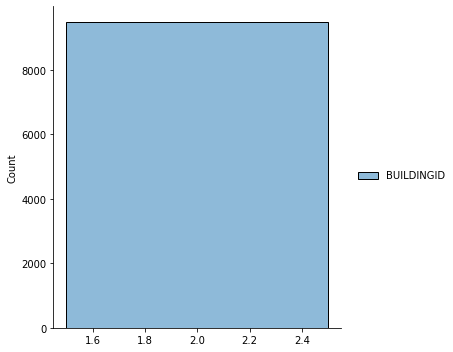

In [152]:
# Making the bar chart for buildings
sns.displot(dataset_ujloc[['BUILDINGID']], kde=False)

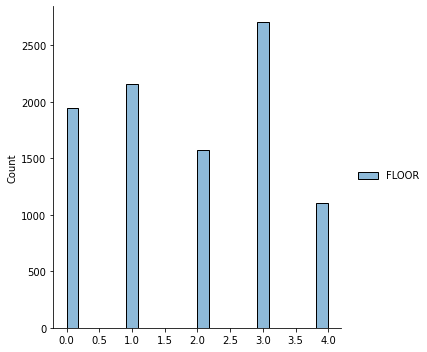

In [153]:
# Making the bar chart for floors
sns.displot(dataset_ujloc[['FLOOR']],kde=False)

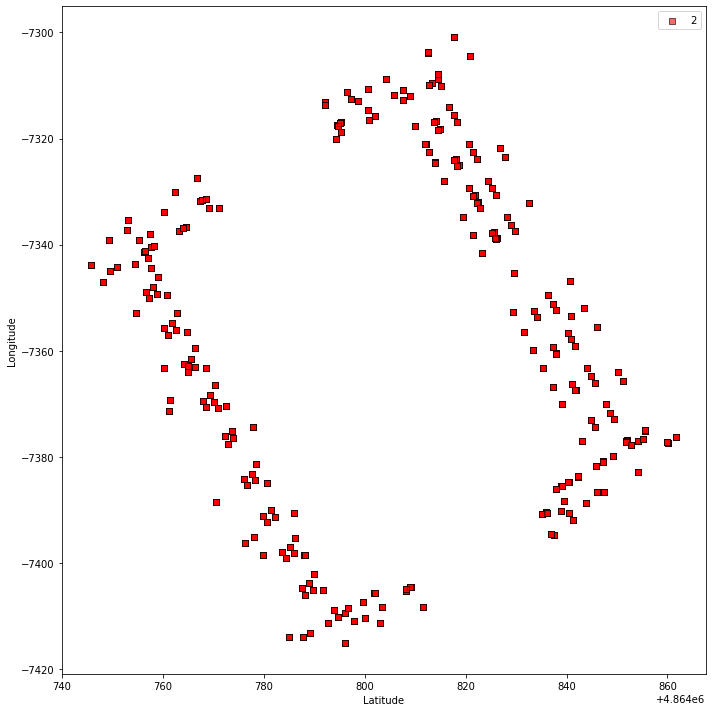

In [154]:
# The scatter plot of the available data points | 14,700 m2
markers = ('s', 'X', 'o')
colors = ('red', 'yellow', 'lightgreen')
cmap = ListedColormap(colors[:len(np.unique(dataset_ujloc['BUILDINGID']))])


fig = plt.figure(figsize=(10,10))
for idx, cl in enumerate(np.unique(dataset_ujloc['BUILDINGID'])):
        plt.scatter(x=dataset_ujloc.loc[dataset_ujloc.BUILDINGID== cl]['LATITUDE'], 
                    y=dataset_ujloc.loc[dataset_ujloc.BUILDINGID== cl]['LONGITUDE'],
                    alpha=0.6, 
                    c=[cmap(idx)],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(loc='upper right')
plt.tight_layout()

<AxesSubplot:xlabel='FLOOR', ylabel='count'>

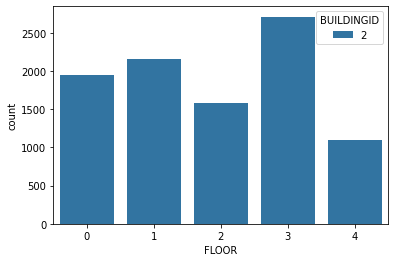

In [155]:
# Buildings 0/1 have 4 floors, building 2 has 5
sns.countplot(x="FLOOR", hue="BUILDINGID", data=dataset_ujloc, orient="v")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


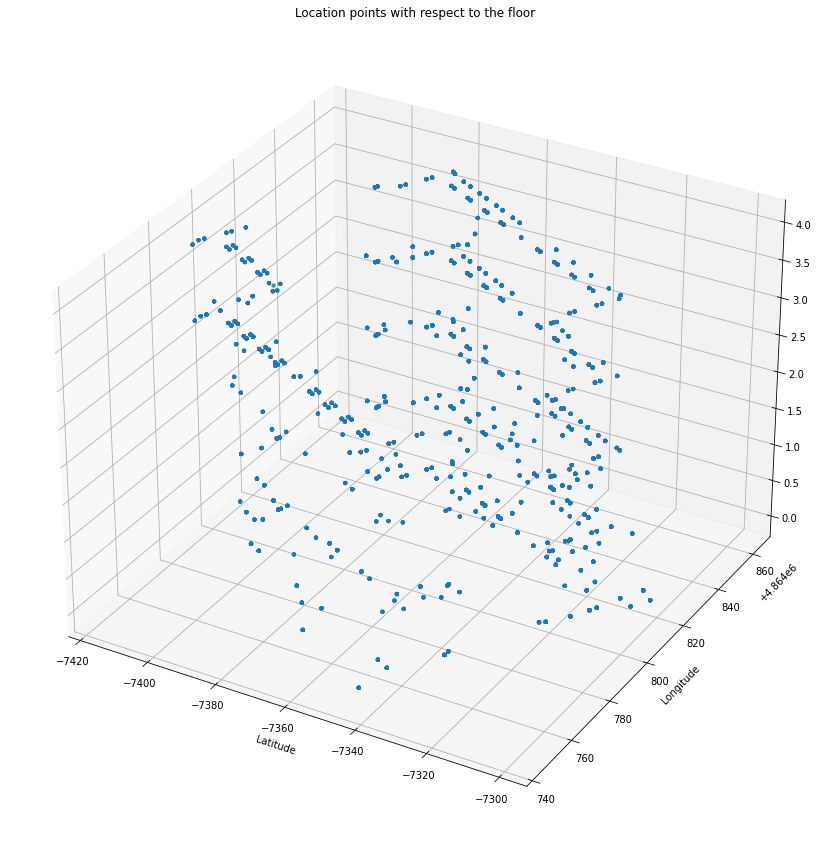

In [156]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
xs = dataset_ujloc['LONGITUDE']
ys = dataset_ujloc['LATITUDE']
zs = dataset_ujloc['FLOOR']
ax.scatter(xs, ys, zs, alpha=0.5, s=10,marker='o')

plt.title("Location points with respect to the floor")

plt.xlabel('Latitude')
plt.ylabel('Longitude')

plt.show()

## 4. Data preprocessing

In [157]:
# Removing the unused columns
dataset_ujloc.drop(["SPACEID", "RELATIVEPOSITION", "USERID", "PHONEID", "TIMESTAMP"], axis=1, inplace=True)
validation_dataset_ujloc.drop(["SPACEID", "RELATIVEPOSITION", "USERID", "PHONEID", "TIMESTAMP"], axis=1, inplace=True)

In [158]:
dataset_ujloc

WAP001  WAP002  WAP003  WAP004  WAP005  WAP006  WAP007  WAP008  WAP009  \
46        100     100     100     100     100     100     100     100     100   
47        100     100     100     100     100     100     100     100     100   
49        100     100     100     100     100     100     100     100     100   
50        100     100     100     100     100     100     100     100     100   
51        100     100     100     100     100     100     100     100     100   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
19926     100     100     100     100     100     100     100     100     100   
19927     100     100     100     100     100     100     100     100     100   
19928     100     100     100     100     100     100     100     100     100   
19931     100     100     100     100     100     100     100     100     100   
19933     100     100     100     100     100     100     100     100     100   

       WAP010  ...  WAP515  WAP516  WAP517  WAP518  WAP519  WAP520  \
46        100  ...     100     100     -93     100     100     100   
47        100  ...     100     100     -89     100     100     100   
49        100  ...     100     100     100     -91     100     100   
50        100  ...     100     100     -90     100     100     100   
51        100  ...     100     100     -92     100     100     100   
...       ...  ...     ...     ...     ...     ...     ...     ...   
19926     100  ...     100     100     -87     100     100     100   
19927     100  ...     100     -84     -77     100     100     100   
19928     100  ...     100     -90     -87     100     100     100   
19931     100  ...     100     100     -91     100     100     100   
19933     100  ...     100     100     100     100     100     100   

         LONGITUDE      LATITUDE  FLOOR  BUILDINGID  
46    -7331.748000  4.864767e+06      3           2  
47    -7331.400500  4.864768e+06      3           2  
49    -7327.492165  4.864767e+06      3           2  
50    -7336.700400  4.864764e+06      3           2  
51    -7337.394800  4.864763e+06      3           2  
...            ...           ...    ...         ...  
19926 -7331.496600  4.864768e+06      1           2  
19927 -7390.734700  4.864835e+06      1           2  
19928 -7331.463800  4.864769e+06      1           2  
19931 -7394.577825  4.864837e+06      1           2  
19933 -7390.620600  4.864836e+06      1           2  

[9492 rows x 524 columns]

### 4.1. Dropping BUILDINGID for cases where we train on a single building

In [159]:
# Removing the building (for scenario with only a building selected)
# dataset_ujloc.drop(["BUILDINGID"], axis=1, inplace=True)
# validation_dataset_ujloc.drop(["BUILDINGID"], axis=1, inplace=True)

In [160]:
# dataset_ujloc.head(5)

### 4.2. Encoding a POINT column (FLOOR+BUILDINGID) for cases of multi-building classification

In [161]:
# Creating the output (target) column for DNN (For the case of FLOOR+Building // otherwise, just floor is enough (for only 1 building seleted))
# dataset_ujloc['POINT'] = dataset_ujloc['FLOOR'].astype(str) + dataset_ujloc['BUILDINGID'].astype(str)
# validation_dataset_ujloc['POINT'] = validation_dataset_ujloc['FLOOR'].astype(str) + \
#                                     validation_dataset_ujloc['BUILDINGID'].astype(str)

In [162]:
# dataset_ujloc.head(5)

In [163]:
# Encoding the FLOOR+BUILDING (=POINT)
# floor_build_encoder = LabelEncoder()
# floor_build_encoder.fit(dataset_ujloc["POINT"])

In [164]:
# floor_build_encoder = floor_build_encoder.transform(dataset_ujloc['POINT'])

In [165]:
# df_point_encoded = pd.DataFrame(floor_build_encoder, columns=['POINT_ENCODED'])

In [166]:
# dataset_ujloc = pd.concat([dataset_ujloc, df_point_encoded], axis=1)

In [167]:
# dataset_ujloc

## ----------------------- Up until here the dataset and validation are the same -------------------

### 4.3. Splitting the data in labels and targets for the first DNN (Step 1)

In [168]:
X = dataset_ujloc.iloc[:, :520].values
y = dataset_ujloc['FLOOR'].values

In [169]:
X

array([[100, 100, 100, ..., 100, 100, 100],
       [100, 100, 100, ..., 100, 100, 100],
       [100, 100, 100, ..., -91, 100, 100],
       ...,
       [100, 100, 100, ..., 100, 100, 100],
       [100, 100, 100, ..., 100, 100, 100],
       [100, 100, 100, ..., 100, 100, 100]], dtype=int64)

In [170]:
y

array([3, 3, 3, ..., 1, 1, 1], dtype=int64)

### 4.4. Splitting the dataset into Training and Test set

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [172]:
X_train

array([[100, 100, 100, ..., 100, 100, 100],
       [100, 100, 100, ..., 100, 100, 100],
       [100, 100, 100, ..., 100, 100, 100],
       ...,
       [100, 100, 100, ..., 100, 100, 100],
       [100, 100, 100, ..., 100, 100, 100],
       [100, 100, 100, ..., 100, 100, 100]], dtype=int64)

### 4.5. Feature scaling

In [173]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test) 

In [174]:
X_train.shape

(7593, 520)

In [175]:
y_train.shape

(7593,)

## 5. Building the first DNN model

### 5.1. Initializing the NN

In [176]:
 nn = tf.keras.models.Sequential()

### 5.2. Adding the input layer and the first hidden layer

In [177]:
# Adding a fully-connected layer (it automatically create the input layer)
# num of neurons = num of features (520 APs)
input_size = 520
nn.add(tf.keras.layers.Dense(input_dim=input_size, units=256, activation='relu'))

### 5.3. Adding the second layer

In [178]:
# Adding a layer with 128 neurons
nn.add(tf.keras.layers.Dense(units=128, activation='relu'))

### 5.4. Adding the output layer

In [179]:
# sotmax for > 2 categories
classes = 5
nn.add(tf.keras.layers.Dense(units=classes, activation='softmax'))

## 6. Training the DNN

### 6.1. Compiling the DNN

In [180]:
# Optimizer = Adam ==> Stochastic Gradient Descent
nn.compile(optimizer = 'adam',
           loss = 'sparse_categorical_crossentropy',
           metrics = ['accuracy'])

### 6.2. Training the ANN on the Training set

In [181]:
nn.fit(X_train, y_train, batch_size=32, epochs=20)

Epoch 1/20
238/238 [==============================] - 2s 4ms/step - loss: 0.2545 - accuracy: 0.9169
Epoch 2/20
238/238 [==============================] - 1s 3ms/step - loss: 0.0657 - accuracy: 0.9767
Epoch 3/20
238/238 [==============================] - 1s 3ms/step - loss: 0.0361 - accuracy: 0.9866
Epoch 4/20
238/238 [==============================] - 1s 3ms/step - loss: 0.0223 - accuracy: 0.9935
Epoch 5/20
238/238 [==============================] - 1s 3ms/step - loss: 0.0168 - accuracy: 0.9953
Epoch 6/20
238/238 [==============================] - 1s 3ms/step - loss: 0.0124 - accuracy: 0.9964
Epoch 7/20
238/238 [==============================] - 1s 3ms/step - loss: 0.0143 - accuracy: 0.9953
Epoch 8/20
238/238 [==============================] - 1s 3ms/step - loss: 0.0108 - accuracy: 0.9967
Epoch 9/20
238/238 [==============================] - 1s 3ms/step - loss: 0.0053 - accuracy: 0.9982
Epoch 10/20
238/238 [==============================] - 1s 3ms/step - loss: 0.0017 - accuracy: 0.9997

## 7. Making predictions and evaluating the model

### 7.1. Predicting the Test set results

In [182]:
y_pred = nn.predict(X_test)

60/60 [==============================] - 0s 1ms/step


In [183]:
y_pred

array([[5.4171813e-14, 1.8739997e-14, 1.4652157e-10, 9.9999988e-01,
        6.8081803e-08],
       [2.7637604e-11, 1.3993844e-12, 1.1552467e-11, 1.7184017e-05,
        9.9998283e-01],
       [2.6561916e-17, 1.1898964e-15, 2.0448296e-12, 1.0000000e+00,
        4.6856803e-09],
       ...,
       [3.2139203e-13, 2.0213815e-12, 3.5805431e-05, 9.9996424e-01,
        1.9084718e-13],
       [9.9999893e-01, 1.1006819e-06, 7.9586081e-11, 2.1819846e-10,
        3.5352637e-11],
       [3.6024791e-18, 6.1717828e-16, 2.3809919e-08, 1.0000000e+00,
        3.6641559e-10]], dtype=float32)

In [184]:
y_pred.shape

(1899, 5)

#### 7.1.1. Transforming the encoded data back to floor number

In [185]:
# we transform  the (1899, 5) floor array back to single value (the number of the floor)

# floor_pred = []
# floors = [i for i in range(5)]
# for arr in y_pred:
#     max_val = max(arr)
#     index_max = np.where(arr == max_val)
#     floor_pred.append(floors[index_max[0][0]])
# floor_pred = np.array(floor_pred)

floor_pred = tf.argmax(y_pred, axis=1)
floor_pred = tf.keras.backend.eval(floor_pred)

In [186]:
floor_pred

array([3, 4, 3, ..., 3, 0, 3], dtype=int64)

In [187]:
y_test

array([3, 4, 3, ..., 3, 0, 3], dtype=int64)

### 7.2. Making the confusion matrix and calculating Accuracy 

In [188]:
cm = confusion_matrix(y_test, floor_pred)
print(cm)
accuracy = accuracy_score(y_test, floor_pred)
print('Accuracy: ', accuracy)

[[401   5   0   0   0]
 [  7 408   3   0   0]
 [  1  11 281   7   0]
 [  0   0   3 557   1]
 [  0   0   0   3 211]]
Accuracy:  0.9784096893101633


In [189]:
print(classification_report(y_test, floor_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       406
           1       0.96      0.98      0.97       418
           2       0.98      0.94      0.96       300
           3       0.98      0.99      0.99       561
           4       1.00      0.99      0.99       214

    accuracy                           0.98      1899
   macro avg       0.98      0.98      0.98      1899
weighted avg       0.98      0.98      0.98      1899



### 7.3. Predicting with the Validation set

In [190]:
X_valid = validation_dataset_ujloc.iloc[:, :520].values
y_valid = validation_dataset_ujloc['FLOOR'].values

In [191]:
X_valid = sc.fit_transform(X_valid)

In [192]:
y_pred_valid = nn.predict(X_valid)
y_pred_valid

9/9 [==============================] - 0s 2ms/step


array([[1.23883019e-08, 1.16272714e-10, 8.14276824e-09, 7.52376795e-01,
        2.47623175e-01],
       [2.78817872e-19, 4.47791599e-21, 1.06832325e-21, 1.90840535e-13,
        1.00000000e+00],
       [1.63753169e-12, 6.44573226e-15, 2.37010385e-15, 3.62540732e-07,
        9.99999642e-01],
       ...,
       [1.31269005e-07, 9.64923359e-08, 2.14209256e-04, 9.99785125e-01,
        5.15248757e-07],
       [5.24992227e-09, 1.86067950e-07, 1.08813138e-05, 9.99987960e-01,
        9.90830017e-07],
       [2.02540396e-05, 2.09577745e-04, 4.73624503e-04, 9.99213815e-01,
        8.27762851e-05]], dtype=float32)

In [193]:
y_pred_valid.shape

(268, 5)

In [194]:
floor_pred_valid = tf.argmax(y_pred_valid, axis=1)
floor_pred_valid = tf.keras.backend.eval(floor_pred_valid)

In [195]:
floor_pred_valid

array([3, 4, 4, 2, 3, 3, 3, 0, 3, 0, 0, 2, 0, 1, 4, 1, 1, 4, 4, 1, 1, 3,
       3, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 2, 1, 2, 1, 3, 2,
       2, 2, 2, 1, 3, 1, 1, 4, 1, 3, 3, 1, 1, 3, 4, 1, 1, 1, 1, 1, 3, 2,
       1, 1, 4, 1, 3, 1, 4, 2, 2, 1, 1, 1, 1, 3, 4, 1, 1, 1, 1, 1, 2, 1,
       1, 4, 1, 1, 1, 3, 1, 1, 1, 4, 1, 3, 1, 1, 1, 4, 3, 1, 1, 4, 3, 1,
       0, 4, 1, 1, 3, 1, 3, 0, 4, 3, 2, 1, 4, 2, 1, 2, 1, 3, 2, 2, 1, 3,
       2, 1, 2, 2, 2, 2, 0, 1, 1, 2, 2, 3, 1, 4, 1, 2, 2, 2, 0, 3, 2, 2,
       2, 1, 3, 2, 2, 4, 1, 1, 3, 1, 1, 4, 2, 2, 2, 4, 3, 2, 0, 2, 3, 3,
       3, 2, 0, 1, 2, 2, 3, 1, 1, 2, 2, 3, 1, 0, 2, 4, 4, 1, 1, 4, 1, 4,
       1, 0, 4, 1, 2, 1, 1, 4, 0, 0, 1, 4, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 4, 4, 4,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3], dtype=int64)

In [196]:
cm = confusion_matrix(y_valid, floor_pred_valid)
print(cm)
accuracy = accuracy_score(y_valid, floor_pred_valid)
print('Accuracy: ', accuracy)

[[21  3  0  0  0]
 [ 2 99  8  2  0]
 [ 0  2 38 14  0]
 [ 0  0  0 37  3]
 [ 0  1  0 10 28]]
Accuracy:  0.832089552238806


In [197]:
print(classification_report(y_valid, floor_pred_valid))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89        24
           1       0.94      0.89      0.92       111
           2       0.83      0.70      0.76        54
           3       0.59      0.93      0.72        40
           4       0.90      0.72      0.80        39

    accuracy                           0.83       268
   macro avg       0.83      0.82      0.82       268
weighted avg       0.86      0.83      0.84       268



## 8. Building the KNN regressor

### 8.1. Creating the second training dataset

#### 8.1.1. Selecting the cluster to which out values correspond to (the Floor)

In [255]:
floor = 0
# floor = floor_pred_valid[0] # TODO: verify how can we change this so it gets the floor by default
mask = dataset_ujloc['FLOOR'] == floor

In [256]:
df_ap = dataset_ujloc.iloc[:, :520][mask]
df_floor = dataset_ujloc['FLOOR'][mask]

In [257]:
X_step_2 = pd.concat([df_ap, df_floor], axis=1).values
y_step_2 = dataset_ujloc[['LONGITUDE', 'LATITUDE']][mask].values

In [258]:
X_step_2

array([[100, 100, 100, ..., 100, 100,   0],
       [100, 100, 100, ..., 100, 100,   0],
       [100, 100, 100, ..., 100, 100,   0],
       ...,
       [100, 100, 100, ..., 100, 100,   0],
       [100, 100, 100, ..., 100, 100,   0],
       [100, 100, 100, ..., 100, 100,   0]], dtype=int64)

In [259]:
y_step_2

array([[  -7404.8357, 4864808.159 ],
       [  -7404.4362, 4864808.8699],
       [  -7405.6817, 4864801.9057],
       ...,
       [  -7314.6117, 4864800.7124],
       [  -7320.0789, 4864794.3278],
       [  -7320.0789, 4864794.3278]])

### 8.3. Splitting the data in Train and Test

In [260]:
X_train_step_2, X_test_step_2, y_train_step_2, y_test_step_2 = train_test_split(X_step_2,
                                                                                y_step_2, 
                                                                                test_size = 0.2, 
                                                                                random_state = 0)

In [261]:
X_train_step_2

array([[100, 100, 100, ..., 100, 100,   0],
       [100, 100, 100, ..., 100, 100,   0],
       [100, 100, 100, ..., 100, 100,   0],
       ...,
       [100, 100, 100, ..., 100, 100,   0],
       [100, 100, 100, ..., 100, 100,   0],
       [100, 100, 100, ..., 100, 100,   0]], dtype=int64)

In [262]:
len(X_train_step_2)

1553

### 8.4. Building the model

In [263]:
knn_regressor = KNeighborsRegressor(n_neighbors=3, weights='distance')
knn_regressor.fit(X_train_step_2, y_train_step_2)

KNeighborsRegressor(n_neighbors=3, weights='distance')

### 8.5. Making predictions and evaluating the model

In [264]:
y_pred_step_2 = knn_regressor.predict(X_test_step_2)
y_pred_step_2

array([[  -7318.70920733, 4864795.29195835],
       [  -7346.1826    , 4864759.0534    ],
       [  -7345.4118    , 4864829.5512    ],
       [  -7406.937921  , 4864806.47221702],
       [  -7377.07826999, 4864842.961439  ],
       [  -7381.2929    , 4864778.5325    ],
       [  -7304.4836    , 4864820.8753    ],
       [  -7317.42084175, 4864822.9448589 ],
       [  -7388.4434234 , 4864817.97127512],
       [  -7378.71011408, 4864849.68237942],
       [  -7343.39910693, 4864749.42992774],
       [  -7369.64020883, 4864844.42724446],
       [  -7343.56913033, 4864828.52878284],
       [  -7313.30854488, 4864803.06128391],
       [  -7345.4118    , 4864829.5512    ],
       [  -7335.57600583, 4864829.28792882],
       [  -7366.2566    , 4864841.1159    ],
       [  -7311.16579563, 4864806.92346359],
       [  -7318.6948    , 4864795.3021    ],
       [  -7307.7743    , 4864814.5994    ],
       [  -7369.22354488, 4864761.38187774],
       [  -7310.7649    , 4864807.6461    ],
       [  

In [265]:
y_pred_step_2.shape

(389, 2)

In [266]:
y_test_step_2.shape

(389, 2)

In [267]:
print(mean_squared_error(y_test_step_2, y_pred_step_2))

103.91153052620609


In [268]:
print(mean_squared_error(y_test_step_2, y_pred_step_2, multioutput='raw_values'))

[164.56680158  43.25625947]


In [269]:
y_pred_step_2 = pd.DataFrame(y_pred_step_2, columns=['long1', 'lat1'])
y_test_step_2 = pd.DataFrame(y_test_step_2, columns=['long2', 'lat2'])
# alculating the Euclidian distance between points
distance_df = pd.DataFrame((y_test_step_2['lat2']-y_pred_step_2['lat1'])**2 + 
                           (y_test_step_2['long2']-y_pred_step_2['long1'])**2)**(1/2)
sum_dist = distance_df.sum()
mean_error = sum_dist/len(distance_df)
mean_error

0    5.952121
dtype: float64

In [270]:
# from math import sin, cos, sqrt, atan2, radians

# # Approximate radius of earth in km
# R = 6373.0

# def calc_dist(lat1, lon1, lat2, lon2):
#     lat1 = radians(lat1)
#     lon1 = radians(lon1)
#     lat2 = radians(lat2)
#     lon2 = radians(lon2)

#     dlon = lon2 - lon1
#     dlat = lat2 - lat1

#     a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
#     c = 2 * atan2(sqrt(a), sqrt(1 - a))

#     distance = R * c
#     return distance

# print("Result: ", distance)
# print("Should be: ", 278.546, "km")

In [271]:
df_final = pd.DataFrame()
df_final = pd.concat([y_pred_step_2, y_test_step_2], axis=1)
df_final

long1          lat1        long2          lat2
0   -7318.709207  4.864795e+06 -7318.694800  4.864795e+06
1   -7346.182600  4.864759e+06 -7346.182600  4.864759e+06
2   -7345.411800  4.864830e+06 -7345.411800  4.864830e+06
3   -7406.937921  4.864806e+06 -7404.835700  4.864808e+06
4   -7377.078270  4.864843e+06 -7377.078270  4.864843e+06
..           ...           ...          ...           ...
384 -7377.133500  4.864852e+06 -7377.133500  4.864852e+06
385 -7390.620600  4.864836e+06 -7390.620600  4.864836e+06
386 -7390.485374  4.864841e+06 -7390.548551  4.864840e+06
387 -7358.261707  4.864841e+06 -7360.539300  4.864838e+06
388 -7360.929468  4.864847e+06 -7357.698200  4.864841e+06

[389 rows x 4 columns]

In [272]:
# earth_radius=6371

# df_final['long1'] = np.radians(df_final['long1'])
# df_final['long2'] = np.radians(df_final['long2'])
# df_final['lat1'] = np.radians(df_final['lat1'])
# df_final['lat2'] = np.radians(df_final['lat2'])


# df_final['a'] = np.sin((df_final['lat2']-df_final['lat1'])/2.0)**2 + \
#     np.cos(df_final['lat1']) * np.cos(df_final['lat2']) * np.sin((df_final['long2']-df_final['long1'])/2.0)**2

# df_final['DISTANCE'] = earth_radius * 2 * np.arcsin(np.sqrt(df_final['a']))
# dist_km = df_final['DISTANCE'].sum().mean()
# dist_m = dist_km
# dist_m

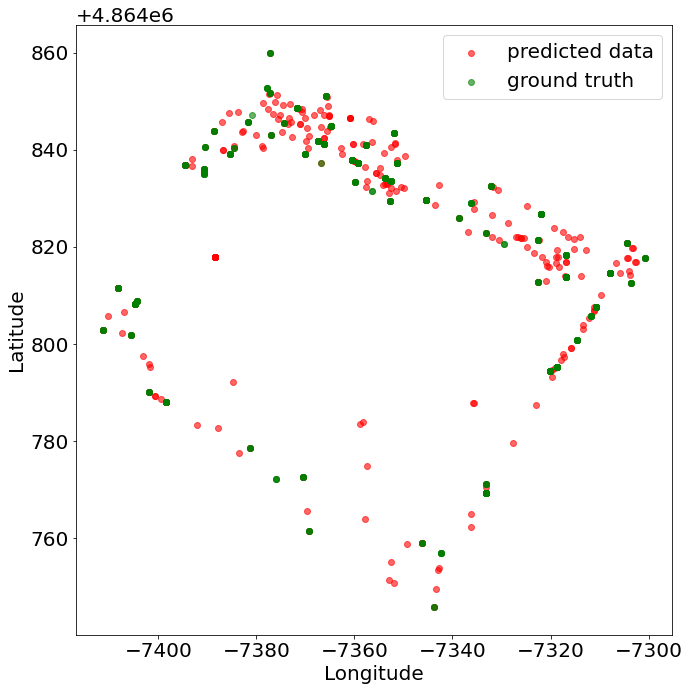

In [273]:
font = {'family' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)


fig = plt.figure(figsize=(10,10))
plt.scatter(x=df_final['long1'], 
            y=df_final['lat1'],
            alpha=0.6, 
            color='red',
            label='predicted data')

plt.scatter(x=df_final['long2'], 
            y=df_final['lat2'],
            alpha=0.6, 
            color='green',
            label='ground truth')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='upper right')
plt.tight_layout()